### Test Model untuk Prediksi Satu Data
menggunakan fungsi prediksi yang berada di file eqt_predict_tf29.py yang sudah di rewrite untuk streaming

In [1]:
import tensorflow as tf
from keras.models import load_model
from eqt_predict_tf29 import SeqSelfAttention, FeedForward, LayerNormalization, f1

gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3050)]
)

model = load_model(
    "components/EqT_original_model.h5",
    custom_objects={
        'SeqSelfAttention': SeqSelfAttention,
        'FeedForward': FeedForward,
        'LayerNormalization': LayerNormalization,
        'f1': f1
    }
)

print("model loaded")

model loaded


Trace key: CLES.AV_20180720034239_EV
Trace shape: (6000, 3)
Start time: 2018-07-20 03:42:40.948000
P picks (s): [4.]
S picks (s): [10.96]


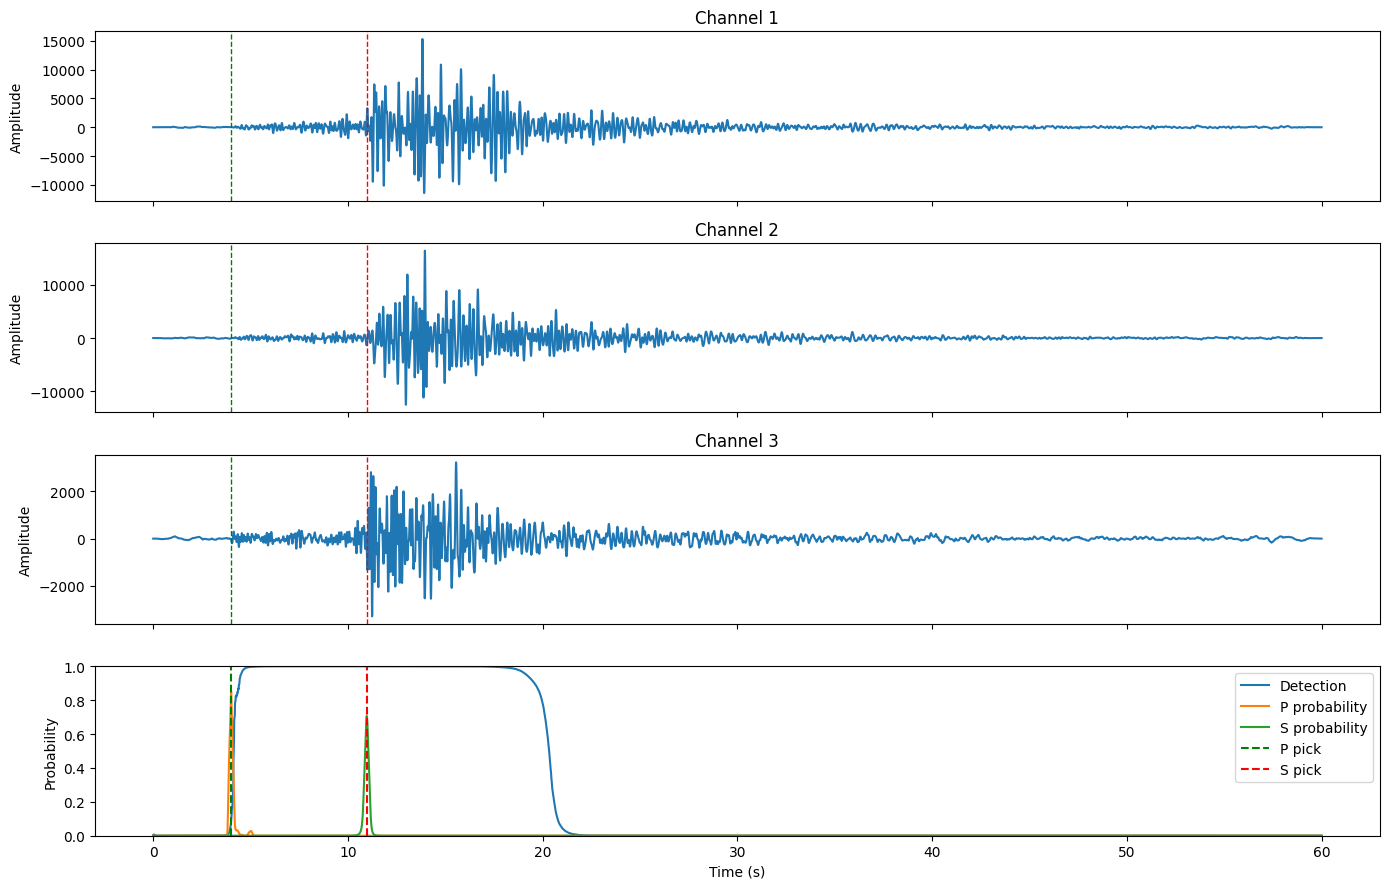

In [23]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from eqt_predict_tf29 import predict

HDF5_PATH = r"components/100hz/waveform.hdf5"
TRACE_INDEX = 66767

FS = 100.0     
WINDOW_SAMPLES = 6000

DET_THRESHOLD = 0.3
P_THRESHOLD   = 0.4
S_THRESHOLD   = 0.4
MIN_DISTANCE_SEC = 0.5

with h5py.File(HDF5_PATH, "r") as f:
    g = f["data"]
    key = list(g.keys())[TRACE_INDEX]
    seismic_trace = g[key][...]        
    start_time = g[key].attrs["trace_start_time"]

print("Trace key:", key)
print("Trace shape:", seismic_trace.shape)
print("Start time:", start_time)

prediction = predict(model, seismic_trace)

det = prediction["DD_mean"]
p   = prediction["PP_mean"]
s   = prediction["SS_mean"]

dt = 1.0 / FS
t = np.arange(WINDOW_SAMPLES) * dt
MIN_DISTANCE = int(MIN_DISTANCE_SEC * FS)

p_peaks, s_peaks = [], []

p_peaks, _ = find_peaks(p, height=P_THRESHOLD, distance=MIN_DISTANCE)
s_peaks, _ = find_peaks(s, height=S_THRESHOLD, distance=MIN_DISTANCE)

p_times = np.array(p_peaks) * dt
s_times = np.array(s_peaks) * dt

print("P picks (s):", p_times)
print("S picks (s):", s_times)

fig, axes = plt.subplots(4, 1, figsize=(14, 9), sharex=True)
channel_titles = ["Channel 1", "Channel 2", "Channel 3"]

for i in range(3):
    axes[i].plot(t, seismic_trace[:, i])
    axes[i].set_title(channel_titles[i])
    axes[i].set_ylabel("Amplitude")

    for pt in p_times:
        axes[i].axvline(pt, color="green", linestyle="--", linewidth=1)

    for st in s_times:
        axes[i].axvline(st, color="red", linestyle="--", linewidth=1)

axes[3].plot(t, det, label="Detection")
axes[3].plot(t, p, label="P probability")
axes[3].plot(t, s, label="S probability")

for pt in p_times:
    axes[3].axvline(pt, color="green", linestyle="--", label="P pick")

for st in s_times:
    axes[3].axvline(st, color="red", linestyle="--", label="S pick")

axes[3].set_ylim(0.0, 1.0)
axes[3].set_ylabel("Probability")
axes[3].set_xlabel("Time (s)")

handles, labels = axes[3].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[3].legend(by_label.values(), by_label.keys(), loc="upper right")

for ax in axes[:-1]:
    ax.label_outer()

plt.tight_layout()
plt.show()
